### 分别计算不同类型

In [1]:
import pandas as pd 
df = pd.read_csv('data/test_3w.csv') 

# 统计每种类型的数量
source_type_counts = df['source_type'].value_counts()

# 根据类型划分数据
for source_type, count in source_type_counts.items():
    # 选择特定类型的数据
    subset = df[df['source_type'] == source_type]

    # 去掉类型名中的单引号和双引号，并将空格替换为下划线
    source_type_cleaned = source_type.replace("'", "").replace('"', '').replace(' ', '_')

    # 将数据保存到 CSV 文件
    subset.to_csv(f'data/{source_type_cleaned}_test.csv', index=False)

In [2]:
import numpy as np

"""
Transformation from raw image data (nanomaggies) to the rgb values displayed
at the legacy viewer https://www.legacysurvey.org/viewer

Code copied from
https://github.com/legacysurvey/imagine/blob/master/map/views.py
"""

def sdss_rgb(imgs, bands, scales=None,
             m = 0.02):
    import numpy as np
    rgbscales = {'u': (2,1.5), #1.0,
                 'g': (2,2.5),
                 'r': (1,1.5),
                 'i': (0,1.0),
                 'z': (0,0.4), #0.3
                 }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
        
    # b,g,r = [rimg * rgbscales[b] for rimg,b in zip(imgs, bands)]
    # r = np.maximum(0, r + m)
    # g = np.maximum(0, g + m)
    # b = np.maximum(0, b + m)
    # I = (r+g+b)/3.
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I

    # R = fI * r / I
    # G = fI * g / I
    # B = fI * b / I
    # # maxrgb = reduce(np.maximum, [R,G,B])
    # # J = (maxrgb > 1.)
    # # R[J] = R[J]/maxrgb[J]
    # # G[J] = G[J]/maxrgb[J]
    # # B[J] = B[J]/maxrgb[J]
    # rgb = np.dstack((R,G,B))
    rgb = np.clip(rgb, 0, 1)
    return rgb

def dr2_rgb(rimgs, bands, **ignored):
    return sdss_rgb(rimgs, bands, scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)



#### DEV

In [3]:
import h5py 
import numpy as np 
import pandas as pd 

file3=h5py.File('data/new_test_3w_old.h5','r')
df3=pd.DataFrame({
    'sfr_fib_p50':file3['specsfr_fib_p50'],
    'lgm_fib_p50':file3['lgm_fib_p50'],
    'ra_1':file3['ra_1'],
    'dec_1':file3['dec_1']
})

img3=file3['processed_images']
import matplotlib.pyplot as plt
# 计算裁剪区域的左上角和右下角坐标
original_length=152
target_length=64
left = (original_length - target_length) // 2
top = (original_length - target_length) // 2
right = left + target_length
bottom = top + target_length
cropped_images = []
for image_array in img3:
    # 裁剪并添加到裁剪后的图像数组
    cropped_image = image_array[:, top:bottom, left:right]
    cropped_images.append(cropped_image)


img_rgb3=[dr2_rgb(i,['g','r','z'])  for i in cropped_images]

image_merged=[]
tmp_list=[]
for i in range(len(img_rgb3)):
    image_merged.append(img_rgb3[i])
    tmp_list.append(i)
        
tmp_dict={'images':image_merged}
df_01=pd.DataFrame(tmp_dict)
df3['img']=df_01
df3

,sfr_fib_p50,lgm_fib_p50,ra_1,dec_1,img
0,-10.784290,9.476273,118.660250,42.544100,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
1,-11.949470,10.525820,218.220610,40.679325,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
2,-10.758330,9.350916,121.988280,34.227340,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
3,-11.876140,10.196710,180.365540,38.300390,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
4,-12.300000,10.159130,139.690190,53.750393,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
...,...,...,...,...,...
29995,-8.690597,8.990757,53.742588,0.409686,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
29996,-9.311631,10.022380,331.276400,-0.899441,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
29997,-9.485988,9.682550,3.766888,1.002308,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."
29998,-9.200964,9.640602,346.954900,22.387688,"[[[0.12719311, 0.12719311, 0.12719311], [0.127..."


In [4]:
len(df3)

30000

In [24]:
df2=pd.read_csv('data/bbSER_test.csv')
len(df2)

25437

In [25]:
DEV = df3[(df3.ra_1.isin(df2.ra_1)) & (df3.dec_1.isin(df2.dec_1))]
len(DEV)

25437

In [26]:
result=pd.read_csv('/Users/yuu/Downloads/ml-dl/stardata/processed_images/result/SER_reuslt.csv')
u_lgm=np.mean(np.array(DEV['lgm_fib_p50'])-np.array(result['lgm']))
u_sfr=np.mean(np.array(DEV['sfr_fib_p50'])-np.array(result['sfr']))
print(f'LGM的u是:{u_lgm},sSFR的u是{u_sfr}')

LGM的u是:-0.04220965968471125,sSFR的u是0.04739533138734913


In [8]:
## 把模型加载进来对不同分区分别进行预测
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np 
import pandas as pd 
import h5py 

In [10]:
## 把模型加载进来对不同分区分别进行预测
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np 
import pandas as pd 
import h5py 

# 自定义对象字典，用于告诉 TensorFlow 如何处理自定义层
custom_objects = {'KerasLayer': hub.KerasLayer}

# 更改一下path
model_path = '/Users/yuu/Downloads/ml-dl/stardata/processed_images/test/ssfr_rmse_0.413_1kb3.h5'

# 加载模型并传递自定义对象字典
final_model = tf.keras.models.load_model(model_path,custom_objects)

In [ ]:
### 这里得去定义一下归一化器 定义一下count_mae

In [11]:
import h5py

file1=h5py.File('/Users/yuu/Downloads/ml-dl/stardata/processed_images/data/new_train_6w.h5','r')

sfr1=file1['specsfr_fib_p50']
lgm1=file1['lgm_fib_p50']

from sklearn.preprocessing import MinMaxScaler
#train sfr
scaler_sfr_train=MinMaxScaler()
scaler_sfr_1=np.array(sfr1).reshape(-1, 1)
scaler_sfr_train.fit(scaler_sfr_1)
#train lgm
scaler_lgm_train=MinMaxScaler()
scaler_lgm_1=np.array(lgm1).reshape(-1, 1)
scaler_lgm_train.fit(scaler_lgm_1)

MinMaxScaler()

In [12]:
file1.keys()

<KeysViewHDF5 ['GroupID', 'GroupSize', 'Separation', 'bptclass', 'brickid', 'cModelMag_r', 'circle_arc', 'circles_radius', 'col1', 'dec_1', 'dec_2', 'e_bv_sfd', 'ebv', 'fiberid', 'index', 'index_old', 'lgm_fib_p50', 'lgm_tot_p50', 'mjd', 'modelMag_r', 'objid', 'oh_p50', 'oval_distances', 'petroMag_g', 'petroMag_r', 'plateid', 'primtarget', 'processed_images', 'ra_1', 'ra_2', 'reliable', 'sectarget', 'sfr_fib_p50', 'sfr_tot_p50', 'snMedian_g', 'snMedian_r', 'sn_median', 'specObjID', 'specsfr_fib_p50', 'specsfr_tot_p50', 'v_disp', 'v_disp_err', 'z', 'z_err', 'z_spec', 'z_warning']>

In [13]:
def count_mae(n1,n2):
    # 计算绝对差值
    n1=np.array(n1)
    n2=np.array(n2)
    absolute_errors = np.abs(n1 - n2)

    # 计算平均绝对误差（MAE）
    mae = np.mean(absolute_errors)

    print("MAE:", mae)

In [14]:
def predict_type(model,img,sfr_true,lgm_true,type_name):
    y=final_model.predict(img)
    y_df=pd.DataFrame()
    y_df['lgm']=pd.DataFrame(y[0])
    y_df['sfr']=pd.DataFrame(y[1])

    sfr_true=np.array(sfr_true).reshape(-1, 1)
    lgm_true=np.array(lgm_true).reshape(-1, 1)

    lgm_pred=np.array(y_df['lgm']).reshape(-1, 1)
    lgm_pred=scaler_lgm_train.inverse_transform(lgm_pred)

    sfr_pred=np.array(y_df['sfr']).reshape(-1, 1)
    sfr_pred=scaler_sfr_train.inverse_transform(sfr_pred)

    print("MAE for lgm:")
    count_mae(lgm_true,lgm_pred)

    mse = np.mean((np.array(lgm_true) - np.array(lgm_pred)) ** 2)
    rmse=np.sqrt(mse)
    sd = np.std(np.array(lgm_true) - np.array(lgm_pred))
    print(f'LGM的MSE是:{mse},RMSE是{rmse},SD是{sd}')

    print("MAE for sfr:")
    count_mae(sfr_true,sfr_pred)

    mse = np.mean((np.array(sfr_true) - np.array(sfr_pred)) ** 2)
    sd = np.std(np.array(sfr_true) - np.array(sfr_pred))
    rmse=np.sqrt(mse)
    print(f'SFR的MSE是:{mse},RMSE是{rmse},SD是{sd}')

    def ll(real_values,predicted_values):
        residuals = [real - predicted for real, predicted in zip(real_values, predicted_values)]

        # 初始化异常值计数器
        exception_count = 0

        # 标记异常值
        for residual in residuals:
            if residual > 0.3 or residual < -0.3:
                exception_count += 1

        # 计算异常值的比例
        total_count = len(residuals)
        percentage_exception = (exception_count / total_count) 

        med = np.median(predicted_values-real_values)
        print(f"outlier:{percentage_exception},MED:{med}")
    
    print(f"SFR的{ll(sfr_true,sfr_pred)}")
    print(f"LGM的{ll(lgm_true,lgm_pred)}")
    
    import matplotlib.pyplot as plt
    fig,ax=plt.subplots(1,2)
    # 创建散点图
    ax[0].scatter(lgm_true, lgm_pred, color='b', marker='o', label='True vs Predicted')

    # 添加标签和标题
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predicted Values')
    ax[0].set_title('LGM True vs LGM Predicted Values')

    # 添加1:1线
    ax[0].plot([min(lgm_true), max(lgm_true)], [min(lgm_true), max(lgm_true)], color='red', linestyle='--', linewidth=2, label='1:1 Line')

    ax[1].scatter(sfr_true, sfr_pred, color='b', marker='o', label='True vs Predicted')

    # 添加标签和标题
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Predicted Values')
    ax[1].set_title('SFR True vs SFR Predicted Values')

    # 添加1:1线
    ax[1].plot([min(sfr_true), max(sfr_true)], [min(sfr_true), max(sfr_true)], color='red', linestyle='--', linewidth=2, label='1:1 Line')


    plt.subplots_adjust(wspace=0.5)  # 调整水平间距为0.5

    # 显示图形
    plt.show()


    result=pd.DataFrame()
    result['sfr']=pd.DataFrame(sfr_pred)
    result['lgm']=pd.DataFrame(lgm_pred)
    #result.to_csv(f'result/{type_name}_reuslt.csv',index=False)
    

#### DEV

61/61 [==============================] - 5s 75ms/step
MAE for lgm:
MAE: 0.11264523055383459
LGM的MSE是:0.02625458535335588,RMSE是0.16203266754996007,SD是0.1611266528542296
MAE for sfr:
MAE: 0.30850619270403185
SFR的MSE是:0.18023852028756848,RMSE是0.4245450745063102,SD是0.42109454734016555


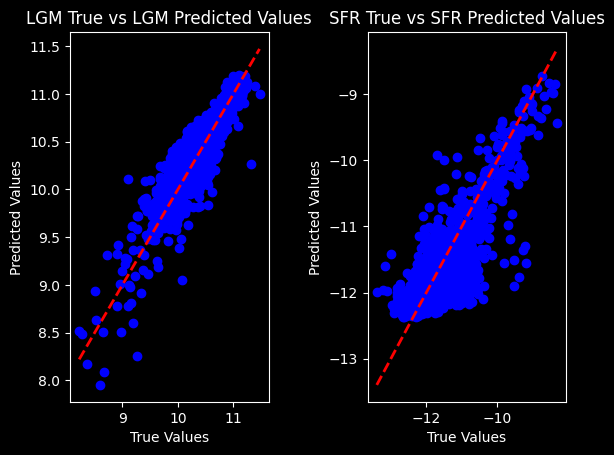

In [19]:
tmp_list=[]
for i in DEV['img']:
    tmp_list.append(i)
tmp_list=np.array(tmp_list)
predict_type(final_model,tmp_list,DEV['sfr_fib_p50'],DEV['lgm_fib_p50'],'DEV')

#### EXP  

15/15 [==============================] - 1s 69ms/step
MAE for lgm:
MAE: 0.21250936384783808
LGM的MSE是:0.08510524728136842,RMSE是0.2917280365020963,SD是0.2779878872202975
MAE for sfr:
MAE: 0.24706465870465213
SFR的MSE是:0.12755485314451553,RMSE是0.35714822293344195,SD是0.34735237016318216


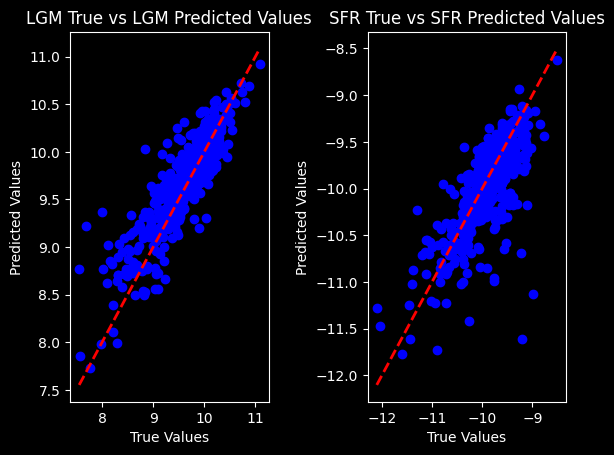

In [22]:
tmp_list=[]
for i in DEV['img']:
    tmp_list.append(i)
tmp_list=np.array(tmp_list)
predict_type(final_model,tmp_list,DEV['sfr_fib_p50'],DEV['lgm_fib_p50'],'EXP')

#### SER

795/795 [==============================] - 56s 71ms/step
MAE for lgm:
MAE: 0.14368733625746008
LGM的MSE是:0.0471193579536776,RMSE是0.2170699379317127,SD是0.21292651953632774
MAE for sfr:
MAE: 0.2977088476062596
SFR的MSE是:0.17421903191247634,RMSE是0.4173955341309683,SD是0.4146959302881413


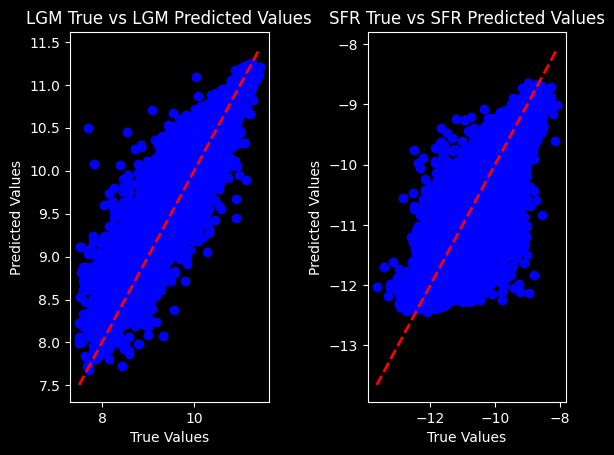

In [25]:
tmp_list=[]
for i in DEV['img']:
    tmp_list.append(i)
tmp_list=np.array(tmp_list)
predict_type(final_model,tmp_list,DEV['sfr_fib_p50'],DEV['lgm_fib_p50'],'SER')

#### REX

2023-10-25 12:45:26.368147: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


68/68 [==============================] - 6s 72ms/step
MAE for lgm:
MAE: 0.20954613085004237
LGM的MSE是:0.08683995861395961,RMSE是0.2946862036369528,SD是0.29008669757331346
MAE for sfr:
MAE: 0.261734149386867
SFR的MSE是:0.1284662976559287,RMSE是0.35842195476271915,SD是0.3492415282331642


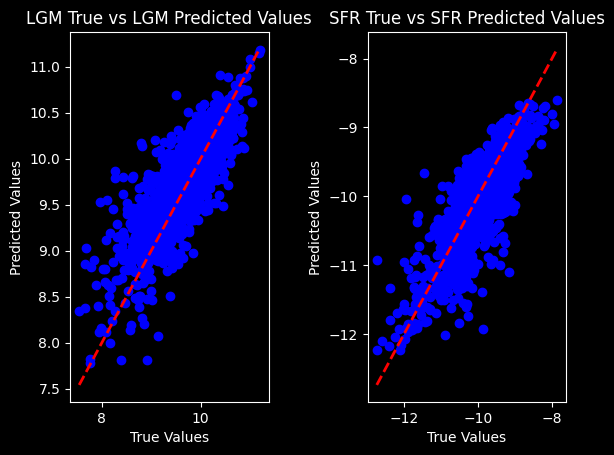

In [15]:
tmp_list=[]
for i in DEV['img']:
    tmp_list.append(i)
tmp_list=np.array(tmp_list)
predict_type(final_model,tmp_list,DEV['sfr_fib_p50'],DEV['lgm_fib_p50'],'REX')

795/795 [==============================] - 56s 70ms/step
MAE for lgm:
MAE: 0.14368733625746008
LGM的MSE是:0.0471193579536776,RMSE是0.2170699379317127,SD是0.21292651953632774
MAE for sfr:
MAE: 0.2977088476062596
SFR的MSE是:0.17421903191247634,RMSE是0.4173955341309683,SD是0.4146959302881413
outlier:0.3617564964421905,MED:-0.01127912841796963
SFR的None
outlier:0.12245940952156308,MED:0.0221131323242183
LGM的None


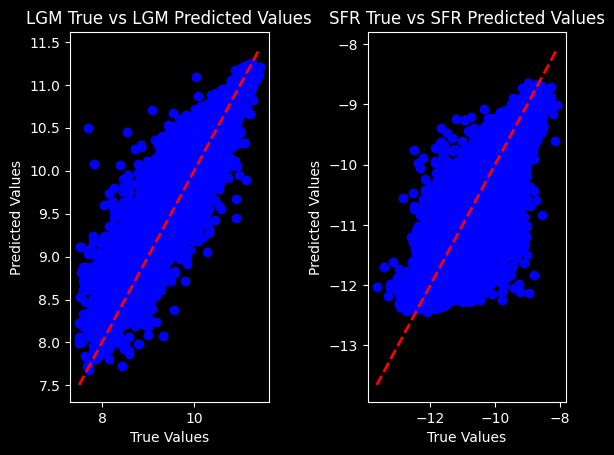

In [27]:
tmp_list=[]
for i in DEV['img']:
    tmp_list.append(i)
tmp_list=np.array(tmp_list)
predict_type(final_model,tmp_list,DEV['sfr_fib_p50'],DEV['lgm_fib_p50'],'EXP')

In [59]:
DEV.drop(columns=['img'],inplace=True)
DEV.to_csv('result/REX_true.csv',index=False)

/var/folders/ty/16fzq05x36915f9bsdrg3kfm0000gn/T/ipykernel_14683/2818044991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEV.drop(columns=['img'],inplace=True)


## 类型作为输入

In [1]:
# import  os, glob
import  random, csv
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras import layers, losses
from tensorflow import keras
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
#import to_rgb

In [2]:
file1=h5py.File('data/new_train_6w.h5','r')
#file2=h5py.File('new_val_1w.h5','r')

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler_sfr_train=MinMaxScaler()
scaler_sfr_1=np.array(file1['specsfr_fib_p50']).reshape(-1, 1)
scaler_sfr_train.fit(scaler_sfr_1)
#train lgm
scaler_lgm_train=MinMaxScaler()
scaler_lgm_1=np.array(file1['lgm_fib_p50']).reshape(-1, 1)
scaler_lgm_train.fit(scaler_lgm_1)

MinMaxScaler()

In [4]:
data_train=pd.DataFrame({
    'sfr_fib_p50':file1['sfr_fib_p50'],
    'lgm_fib_p50':file1['lgm_fib_p50'],
    'ra_1':file1['ra_1'],
    'dec_1':file1['dec_1']
})
sfr1=file1['sfr_fib_p50']
lgm1=file1['lgm_fib_p50']
img1=file1['processed_images']

data_val=pd.DataFrame({
    'sfr_fib_p50':file2['sfr_fib_p50'],
    'lgm_fib_p50':file2['lgm_fib_p50'],
    'ra_1':file2['ra_1'],
    'dec_1':file2['dec_1']
})
sfr2=file2['sfr_fib_p50']
lgm2=file2['lgm_fib_p50']
img2=file2['processed_images']

In [7]:
import matplotlib.pyplot as plt
# 计算裁剪区域的左上角和右下角坐标
original_length=152
target_length=64
left = (original_length - target_length) // 2
top = (original_length - target_length) // 2
right = left + target_length
bottom = top + target_length

cropped_images = []
for image_array in img1:
    # 裁剪并添加到裁剪后的图像数组
    cropped_image = image_array[:, top:bottom, left:right]
    cropped_images.append(cropped_image)

img_rgb1=[dr2_rgb(i,['g','r','z'])  for i in cropped_images]
img_rgb1 = np.array(img_rgb1)

cropped_images = []
for image_array in img2:
    # 裁剪并添加到裁剪后的图像数组
    cropped_image = image_array[:, top:bottom, left:right]
    cropped_images.append(cropped_image)


img_rgb2=[dr2_rgb(i,['g','r','z'])  for i in cropped_images]
img_rgb2 = np.array(img_rgb2)

In [8]:
image_merged=[]
tmp_list=[]
for i in range(len(img_rgb1)):
    image_merged.append(img_rgb1[i])
    tmp_list.append(i)
        
tmp_dict={'images':image_merged}
df_01=pd.DataFrame(tmp_dict)
data_train['img']=df_01


image_merged=[]
tmp_list=[]
for i in range(len(img_rgb2)):
    image_merged.append(img_rgb2[i])
    tmp_list.append(i)
        
tmp_dict={'images':image_merged}
df_01=pd.DataFrame(tmp_dict)
data_val['img']=df_01

print(len(data_train),len(data_val))

40000 10000


In [12]:
df_train=pd.read_csv('../train_4w.csv')
df_val=pd.read_csv('../val_1w.csv')

In [17]:
merged_train = df_train.merge(data_train, on=['ra_1', 'dec_1'], how='inner')
merged_val = df_val.merge(data_val, on=['ra_1', 'dec_1'], how='inner')

In [19]:
merged_train['source_type']

0        b"b'DEV'"
1        b"b'SER'"
2        b"b'SER'"
3        b"b'SER'"
4        b"b'SER'"
           ...    
39995    b"b'SER'"
39996    b"b'SER'"
39997    b"b'SER'"
39998    b"b'SER'"
39999    b"b'SER'"
Name: source_type, Length: 40000, dtype: object

In [26]:
merged_train['type'], mapping_index = pd.factorize(merged_train['source_type'])
merged_val['type'], _ = pd.factorize(merged_val['source_type'])
mapping_dict = {index: category for index, category in enumerate(merged_train['source_type'].unique())}
print(mapping_dict)

{0: 'b"b\'DEV\'"', 1: 'b"b\'SER\'"', 2: 'b"b\'REX\'"', 3: 'b"b\'EXP\'"'}


In [53]:
merged_val['type'], _ = pd.factorize(merged_val['source_type'])
dict = {index: category for index, category in enumerate(merged_train['source_type'].unique())}
print(dict)


{0: 'b"b\'DEV\'"', 1: 'b"b\'SER\'"', 2: 'b"b\'REX\'"', 3: 'b"b\'EXP\'"'}


In [37]:
from sklearn.preprocessing import MinMaxScaler
#train sfr
scaler_sfr_train=MinMaxScaler()
scaler_sfr_1=np.array(sfr1).reshape(-1, 1)
scaler_sfr_train.fit(scaler_sfr_1)
scaler_sfr_1=np.array(merged_train['sfr_fib_p50_x']).reshape(-1, 1)
scaler_sfr_1 = scaler_sfr_train.transform(scaler_sfr_1)
#train lgm
scaler_lgm_train=MinMaxScaler()
scaler_lgm_1=np.array(lgm1).reshape(-1, 1)
scaler_lgm_train.fit(scaler_lgm_1)
scaler_lgm_1=np.array(merged_train['lgm_fib_p50_x']).reshape(-1, 1)
scaler_lgm_1 = scaler_lgm_train.transform(scaler_lgm_1)
# #val sfr
# scaler_sfr_val=MinMaxScaler()
scaler_sfr_2=np.array(merged_val['sfr_fib_p50_x']).reshape(-1, 1)
scaler_sfr_2 = scaler_sfr_train.transform(scaler_sfr_2)
# #val lgm
# scaler_lgm_val=MinMaxScaler()
scaler_lgm_2=np.array(merged_val['lgm_fib_p50_x']).reshape(-1, 1)
scaler_lgm_2 = scaler_lgm_train.transform(scaler_lgm_2)

In [38]:
combined_array_1 = np.concatenate((scaler_lgm_1, scaler_sfr_1), axis=1)
combined_array_2 = np.concatenate((scaler_lgm_2, scaler_sfr_2), axis=1)
combined_array_1.shape

(40000, 2)

In [42]:
train_list=[]
for i in merged_train['img']:
    train_list.append(i)
train_list=np.array(train_list)

val_list=[]
for i in merged_val['img']:
    val_list.append(i)
val_list=np.array(val_list)

In [43]:
with tf.device("CPU"):
    train_ds=tf.data.Dataset.from_tensor_slices((
        {'image_input': train_list, 'data': np.array(merged_train['type'])},combined_array_1
    ))
    val_ds=tf.data.Dataset.from_tensor_slices((
        {'image_input': val_list, 'data': np.array(merged_val['type'])},combined_array_2
    ))

In [44]:
seed_value = 42
tf.random.set_seed(seed_value)


batch_size = 128
train_ds = train_ds.shuffle(buffer_size=4000)  
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def objective(trial):
    lr = trial.suggest_categorical('learning_rate', [3e-4, 3e-4,1e-4, 1e-3]  )
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.25,0.3])
    dense_units = trial.suggest_categorical('dense_units', [64, 128,256,512, 1024])
    #batch_size = trial.suggest_categorical('batch_size', [64, 128])
    print('##########################################################################################')
    print(f'Learning Rate: {lr}, Dropout Rate: {dropout_rate}, Dense Units: {dense_units}')
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))

    # 特征提取层
    feature_extractor_layer = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b3-feature-vector/versions/2", trainable=True)(input_layer)

    # 批量归一化层
    #batch_norm_layer = tf.keras.layers.BatchNormalization()(feature_extractor_layer)

    # Dropout层
    dropout_layer = tf.keras.layers.Dropout(dropout_rate)(feature_extractor_layer)

    # 全连接层
    dense_layer = tf.keras.layers.Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dropout_layer)

    # 输出层1，与标签1的类型匹配
    output_1 = tf.keras.layers.Dense(1, activation='linear', name='output_1')(dense_layer)

    # 输出层2，与标签2的类型匹配
    output_2 = tf.keras.layers.Dense(1, activation='linear', name='output_2')(dense_layer)

    # 创建多输出模型
    m = tf.keras.models.Model(inputs=input_layer, outputs=[output_1, output_2])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    m.compile(optimizer=optimizer,
                   loss='mae',
                   metrics=['mae'])
    
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=5
    )
    epoch=10
    history=m.fit(train_ds,
                validation_data=val_ds,
                validation_freq=1,
                epochs=epoch,
                callbacks=[early_stopping])
    
    last_epoch_val_loss = history.history['val_loss'][-1]
    
    return last_epoch_val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-10-10 08:34:39,188] A new study created in memory with name: no-name-ae8fbe3f-848e-440d-be42-c6f4bbf32a3d


##########################################################################################
Learning Rate: 0.0003, Dropout Rate: 0.25, Dense Units: 128
Epoch 1/10
313/313 [==============================] - 56s 116ms/step - loss: 0.4906 - output_1_loss: 0.1232 - output_2_loss: 0.1511 - output_1_mae: 0.1232 - output_2_mae: 0.1511 - val_loss: 0.3636 - val_output_1_loss: 0.0613 - val_output_2_loss: 0.1089 - val_output_1_mae: 0.0613 - val_output_2_mae: 0.1089
Epoch 2/10
313/313 [==============================] - 34s 109ms/step - loss: 0.3397 - output_1_loss: 0.0644 - output_2_loss: 0.1069 - output_1_mae: 0.0644 - output_2_mae: 0.1069 - val_loss: 0.2935 - val_output_1_loss: 0.0513 - val_output_2_loss: 0.0990 - val_output_1_mae: 0.0513 - val_output_2_mae: 0.0990
Epoch 3/10
313/313 [==============================] - 34s 109ms/step - loss: 0.2754 - output_1_loss: 0.0569 - output_2_loss: 0.0985 - output_1_mae: 0.0569 - output_2_mae: 0.0985 - val_loss: 0.2431 - val_output_1_loss: 0.0474 - val_outp

[I 2023-10-10 08:41:18,001] Trial 0 finished with value: 0.1389477401971817 and parameters: {'learning_rate': 0.0003, 'dropout_rate': 0.25, 'dense_units': 128}. Best is trial 0 with value: 0.1389477401971817.


##########################################################################################
Learning Rate: 0.0001, Dropout Rate: 0.25, Dense Units: 256
Epoch 1/10
313/313 [==============================] - 53s 114ms/step - loss: 0.8575 - output_1_loss: 0.2265 - output_2_loss: 0.2066 - output_1_mae: 0.2265 - output_2_mae: 0.2066 - val_loss: 0.6877 - val_output_1_loss: 0.1439 - val_output_2_loss: 0.1357 - val_output_1_mae: 0.1439 - val_output_2_mae: 0.1357
Epoch 2/10
313/313 [==============================] - 34s 109ms/step - loss: 0.6086 - output_1_loss: 0.0894 - output_2_loss: 0.1290 - output_1_mae: 0.0894 - output_2_mae: 0.1290 - val_loss: 0.6162 - val_output_1_loss: 0.1209 - val_output_2_loss: 0.1239 - val_output_1_mae: 0.1209 - val_output_2_mae: 0.1239
Epoch 3/10
313/313 [==============================] - 34s 109ms/step - loss: 0.5421 - output_1_loss: 0.0739 - output_2_loss: 0.1163 - output_1_mae: 0.0739 - output_2_mae: 0.1163 - val_loss: 0.5172 - val_output_1_loss: 0.0720 - val_outp

[I 2023-10-10 08:47:55,856] Trial 1 finished with value: 0.22858354449272156 and parameters: {'learning_rate': 0.0001, 'dropout_rate': 0.25, 'dense_units': 256}. Best is trial 0 with value: 0.1389477401971817.


##########################################################################################
Learning Rate: 0.0001, Dropout Rate: 0.3, Dense Units: 1024
Epoch 1/10
313/313 [==============================] - 53s 114ms/step - loss: 1.5173 - output_1_loss: 0.1736 - output_2_loss: 0.1799 - output_1_mae: 0.1736 - output_2_mae: 0.1799 - val_loss: 1.3978 - val_output_1_loss: 0.1586 - val_output_2_loss: 0.1494 - val_output_1_mae: 0.1586 - val_output_2_mae: 0.1494
Epoch 2/10
313/313 [==============================] - 34s 109ms/step - loss: 1.2264 - output_1_loss: 0.0876 - output_2_loss: 0.1263 - output_1_mae: 0.0876 - output_2_mae: 0.1263 - val_loss: 1.1850 - val_output_1_loss: 0.1136 - val_output_2_loss: 0.1375 - val_output_1_mae: 0.1136 - val_output_2_mae: 0.1375
Epoch 3/10
313/313 [==============================] - 34s 109ms/step - loss: 1.0445 - output_1_loss: 0.0723 - output_2_loss: 0.1153 - output_1_mae: 0.0723 - output_2_mae: 0.1153 - val_loss: 0.9912 - val_output_1_loss: 0.0878 - val_outp

[I 2023-10-10 08:54:30,314] Trial 2 finished with value: 0.29290494322776794 and parameters: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'dense_units': 1024}. Best is trial 0 with value: 0.1389477401971817.


##########################################################################################
Learning Rate: 0.0003, Dropout Rate: 0.25, Dense Units: 256
Epoch 1/10
313/313 [==============================] - 54s 114ms/step - loss: 0.6764 - output_1_loss: 0.1289 - output_2_loss: 0.1546 - output_1_mae: 0.1289 - output_2_mae: 0.1546 - val_loss: 0.5153 - val_output_1_loss: 0.0637 - val_output_2_loss: 0.1131 - val_output_1_mae: 0.0637 - val_output_2_mae: 0.1131
Epoch 2/10
313/313 [==============================] - 34s 109ms/step - loss: 0.4533 - output_1_loss: 0.0641 - output_2_loss: 0.1073 - output_1_mae: 0.0641 - output_2_mae: 0.1073 - val_loss: 0.3763 - val_output_1_loss: 0.0497 - val_output_2_loss: 0.0994 - val_output_1_mae: 0.0497 - val_output_2_mae: 0.0994
Epoch 3/10
313/313 [==============================] - 34s 109ms/step - loss: 0.3356 - output_1_loss: 0.0562 - output_2_loss: 0.0985 - output_1_mae: 0.0562 - output_2_mae: 0.0985 - val_loss: 0.2830 - val_output_1_loss: 0.0476 - val_outp

[I 2023-10-10 09:01:06,095] Trial 3 finished with value: 0.13842256367206573 and parameters: {'learning_rate': 0.0003, 'dropout_rate': 0.25, 'dense_units': 256}. Best is trial 3 with value: 0.13842256367206573.


##########################################################################################
Learning Rate: 0.0003, Dropout Rate: 0.25, Dense Units: 1024
Epoch 1/10
313/313 [==============================] - 55s 115ms/step - loss: 1.2831 - output_1_loss: 0.1161 - output_2_loss: 0.1497 - output_1_mae: 0.1161 - output_2_mae: 0.1497 - val_loss: 1.0201 - val_output_1_loss: 0.1240 - val_output_2_loss: 0.1095 - val_output_1_mae: 0.1240 - val_output_2_mae: 0.1095
Epoch 2/10
313/313 [==============================] - 34s 108ms/step - loss: 0.7627 - output_1_loss: 0.0640 - output_2_loss: 0.1071 - output_1_mae: 0.0640 - output_2_mae: 0.1071 - val_loss: 0.6024 - val_output_1_loss: 0.0775 - val_output_2_loss: 0.1039 - val_output_1_mae: 0.0775 - val_output_2_mae: 0.1039
Epoch 3/10
313/313 [==============================] - 34s 110ms/step - loss: 0.4575 - output_1_loss: 0.0563 - output_2_loss: 0.0985 - output_1_mae: 0.0563 - output_2_mae: 0.0985 - val_loss: 0.3502 - val_output_1_loss: 0.0486 - val_out

[I 2023-10-10 09:07:43,169] Trial 4 finished with value: 0.14147359132766724 and parameters: {'learning_rate': 0.0003, 'dropout_rate': 0.25, 'dense_units': 1024}. Best is trial 3 with value: 0.13842256367206573.


##########################################################################################
Learning Rate: 0.0003, Dropout Rate: 0.25, Dense Units: 256
Epoch 1/10
313/313 [==============================] - 53s 113ms/step - loss: 0.6596 - output_1_loss: 0.1197 - output_2_loss: 0.1484 - output_1_mae: 0.1197 - output_2_mae: 0.1484 - val_loss: 0.5193 - val_output_1_loss: 0.0717 - val_output_2_loss: 0.1101 - val_output_1_mae: 0.0717 - val_output_2_mae: 0.1101
Epoch 2/10
313/313 [==============================] - 34s 110ms/step - loss: 0.4546 - output_1_loss: 0.0648 - output_2_loss: 0.1073 - output_1_mae: 0.0648 - output_2_mae: 0.1073 - val_loss: 0.3863 - val_output_1_loss: 0.0585 - val_output_2_loss: 0.0986 - val_output_1_mae: 0.0585 - val_output_2_mae: 0.0986
Epoch 3/10
313/313 [==============================] - 34s 110ms/step - loss: 0.3386 - output_1_loss: 0.0565 - output_2_loss: 0.0980 - output_1_mae: 0.0565 - output_2_mae: 0.0980 - val_loss: 0.2871 - val_output_1_loss: 0.0483 - val_outp

[I 2023-10-10 09:14:20,928] Trial 5 finished with value: 0.14076067507266998 and parameters: {'learning_rate': 0.0003, 'dropout_rate': 0.25, 'dense_units': 256}. Best is trial 3 with value: 0.13842256367206573.


##########################################################################################
Learning Rate: 0.0003, Dropout Rate: 0.3, Dense Units: 256
Epoch 1/10
313/313 [==============================] - 53s 114ms/step - loss: 0.6725 - output_1_loss: 0.1201 - output_2_loss: 0.1587 - output_1_mae: 0.1201 - output_2_mae: 0.1587 - val_loss: 0.5367 - val_output_1_loss: 0.0850 - val_output_2_loss: 0.1107 - val_output_1_mae: 0.0850 - val_output_2_mae: 0.1107
Epoch 2/10
313/313 [==============================] - 34s 110ms/step - loss: 0.4605 - output_1_loss: 0.0661 - output_2_loss: 0.1071 - output_1_mae: 0.0661 - output_2_mae: 0.1071 - val_loss: 0.3961 - val_output_1_loss: 0.0616 - val_output_2_loss: 0.0995 - val_output_1_mae: 0.0616 - val_output_2_mae: 0.0995
Epoch 3/10
313/313 [==============================] - 34s 108ms/step - loss: 0.3459 - output_1_loss: 0.0573 - output_2_loss: 0.0987 - output_1_mae: 0.0573 - output_2_mae: 0.0987 - val_loss: 0.3002 - val_output_1_loss: 0.0554 - val_outpu

[I 2023-10-10 09:21:00,165] Trial 6 finished with value: 0.144614115357399 and parameters: {'learning_rate': 0.0003, 'dropout_rate': 0.3, 'dense_units': 256}. Best is trial 3 with value: 0.13842256367206573.


##########################################################################################
Learning Rate: 0.001, Dropout Rate: 0.25, Dense Units: 512
Epoch 1/10
313/313 [==============================] - 53s 114ms/step - loss: 0.6552 - output_1_loss: 0.0902 - output_2_loss: 0.1266 - output_1_mae: 0.0902 - output_2_mae: 0.1266 - val_loss: 0.3217 - val_output_1_loss: 0.0546 - val_output_2_loss: 0.1003 - val_output_1_mae: 0.0546 - val_output_2_mae: 0.1003
Epoch 2/10
313/313 [==============================] - 34s 108ms/step - loss: 0.2310 - output_1_loss: 0.0570 - output_2_loss: 0.0976 - output_1_mae: 0.0570 - output_2_mae: 0.0976 - val_loss: 0.1880 - val_output_1_loss: 0.0589 - val_output_2_loss: 0.1003 - val_output_1_mae: 0.0589 - val_output_2_mae: 0.1003
Epoch 3/10
313/313 [==============================] - 34s 107ms/step - loss: 0.1632 - output_1_loss: 0.0537 - output_2_loss: 0.0929 - output_1_mae: 0.0537 - output_2_mae: 0.0929 - val_loss: 0.1530 - val_output_1_loss: 0.0498 - val_outpu

[I 2023-10-10 09:27:32,046] Trial 7 finished with value: 0.13422828912734985 and parameters: {'learning_rate': 0.001, 'dropout_rate': 0.25, 'dense_units': 512}. Best is trial 7 with value: 0.13422828912734985.


##########################################################################################
Learning Rate: 0.001, Dropout Rate: 0.25, Dense Units: 256
Epoch 1/10
313/313 [==============================] - 53s 114ms/step - loss: 0.5059 - output_1_loss: 0.0893 - output_2_loss: 0.1240 - output_1_mae: 0.0893 - output_2_mae: 0.1240 - val_loss: 0.3012 - val_output_1_loss: 0.0494 - val_output_2_loss: 0.1018 - val_output_1_mae: 0.0494 - val_output_2_mae: 0.1018
Epoch 2/10
313/313 [==============================] - 34s 109ms/step - loss: 0.2328 - output_1_loss: 0.0562 - output_2_loss: 0.0965 - output_1_mae: 0.0562 - output_2_mae: 0.0965 - val_loss: 0.1748 - val_output_1_loss: 0.0464 - val_output_2_loss: 0.0925 - val_output_1_mae: 0.0464 - val_output_2_mae: 0.0925
Epoch 3/10
313/313 [==============================] - 34s 109ms/step - loss: 0.1646 - output_1_loss: 0.0526 - output_2_loss: 0.0920 - output_1_mae: 0.0526 - output_2_mae: 0.0920 - val_loss: 0.1478 - val_output_1_loss: 0.0436 - val_outpu

[I 2023-10-10 09:34:03,610] Trial 8 finished with value: 0.15335528552532196 and parameters: {'learning_rate': 0.001, 'dropout_rate': 0.25, 'dense_units': 256}. Best is trial 7 with value: 0.13422828912734985.


##########################################################################################
Learning Rate: 0.001, Dropout Rate: 0.3, Dense Units: 64
Epoch 1/10
313/313 [==============================] - 53s 115ms/step - loss: 0.3245 - output_1_loss: 0.1006 - output_2_loss: 0.1294 - output_1_mae: 0.1006 - output_2_mae: 0.1294 - val_loss: 0.2152 - val_output_1_loss: 0.0535 - val_output_2_loss: 0.0986 - val_output_1_mae: 0.0535 - val_output_2_mae: 0.0986
Epoch 2/10
313/313 [==============================] - 34s 108ms/step - loss: 0.1978 - output_1_loss: 0.0578 - output_2_loss: 0.0988 - output_1_mae: 0.0578 - output_2_mae: 0.0988 - val_loss: 0.1693 - val_output_1_loss: 0.0500 - val_output_2_loss: 0.0950 - val_output_1_mae: 0.0500 - val_output_2_mae: 0.0950
Epoch 3/10
313/313 [==============================] - 34s 109ms/step - loss: 0.1623 - output_1_loss: 0.0535 - output_2_loss: 0.0933 - output_1_mae: 0.0535 - output_2_mae: 0.0933 - val_loss: 0.1957 - val_output_1_loss: 0.0834 - val_output_

In [45]:
# param1_input = tf.keras.Input(shape=(1,), name='input_1')
# param2_input = tf.keras.Input(shape=(1,), name='input_2')
data_input = tf.keras.layers.Input(shape=(1,), name="data_input")

#merged_inputs = layers.concatenate([param1_input, param2_input],name='merged_input')
merged_model = tf.keras.layers.Dense(units=1024, activation='relu')(data_input)
merged_model = tf.keras.layers.Dense(64, activation='relu', name="data_dense")(merged_model)
merged_output = tf.keras.layers.Dropout(0.5, name="merged_output")(merged_model)
print(merged_output.shape)

(None, 64)


In [47]:
image_input = tf.keras.layers.Input(shape=(64, 64, 3),name='image_input')

# 特征提取层
feature_extractor_layer = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b3-feature-vector/versions/2", trainable=True)(image_input)

# Dropout层
dropout_layer = tf.keras.layers.Dropout(0.25)(feature_extractor_layer)

# 全连接层
img_output = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),name='image_output')(dropout_layer)
print(img_output.shape)

(None, 64)


In [51]:
x = tf.keras.layers.concatenate([img_output,merged_output], name="concat_data_img")

output_1 = tf.keras.layers.Dense(2, activation='linear', name='output_1')(x)
final_model = Model(inputs = [(data_input,image_input)], outputs = output_1)

final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 data_input (InputLayer)        [(None, 1)]          0           []                               


                                                                                                  
 keras_layer_1 (KerasLayer)     (None, 1536)         12930622    ['image_input[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 1024)         2048        ['data_input[0][0]']             
                                                                                                  
 dropout (Dropout)              (None, 1536)         0           ['keras_layer_1[0][0]']          
                                                                                                  
 data_dense (Dense)             (None, 64)           65600       ['dense[0][0]']                  
                                                                                                  
 image_output (Dense)           (None, 64)           98368       ['dropout[0][0]']                
          

In [12]:
# #Learning Rate: 0.001, Dropout Rate: 0.25, Dense Units: 512
# import tensorflow as tf

# input_layer = tf.keras.layers.Input(shape=(64, 64, 3))

# # 特征提取层
# feature_extractor_layer = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b3-feature-vector/versions/2", trainable=True)(input_layer)

# # Dropout层
# dropout_layer = tf.keras.layers.Dropout(0.25)(feature_extractor_layer)

# # 全连接层
# dense_layer = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dropout_layer)

# # 输出层1，与标签1的类型匹配
# output_1 = tf.keras.layers.Dense(1, activation='linear', name='output_1')(dense_layer)

# # 输出层2，与标签2的类型匹配
# output_2 = tf.keras.layers.Dense(1, activation='linear', name='output_2')(dense_layer)

# # 创建多输出模型
# final_model = tf.keras.models.Model(inputs=input_layer, outputs=[output_1, output_2])
# #Learning Rate: 0.0003, Dropout Rate: 0.5, Dense Units: 128


In [52]:
def get_loss(y_true, y_pred):
    y_sigma=y_pred[1]
    y_true=y_pred[0]
    loss = (tf.math.log(y_sigma) / 2.0 + (y_true - y_pred)**2 / (2.0 * y_sigma))
    return tf.reduce_mean(loss) + 5.0
#from tensorflow.keras.optimizers import legacy as keras_legacy_optimizers
#Learning Rate: 0.0001, Dropout Rate: 0.1, Dense Units: 512
initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate, 
#         decay_steps=10,     
#         decay_rate=0.1,   
#         staircase=True)
boundaries=[15,25]
values=[initial_learning_rate,initial_learning_rate*0.1,initial_learning_rate*0.1*0.96]
learning_rate_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
#optimizer = keras_legacy_optimizers.Adam(learning_rate=1e-4)

final_model.compile(optimizer=optimizer,
               loss='mae',
               metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=5
)
epoch=50
history=final_model.fit(train_ds,
            validation_data=val_ds,
            validation_freq=1,
            epochs=epoch,
            callbacks=[early_stopping])

Epoch 1/50


2023-10-12 19:14:15.775405: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  5/313 [..............................] - ETA: 6:05 - loss: 0.5169 - mae: 0.3941

KeyboardInterrupt: 

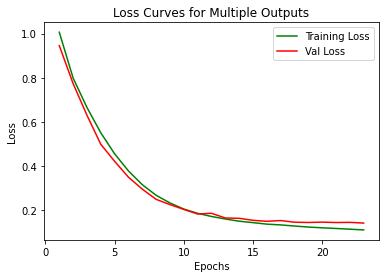

In [15]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
# loss_output_1 = history.history['output_1_loss']
# loss_output_2 = history.history['output_2_loss']
val_loss=history.history['val_loss']
# 创建损失值曲线图
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'g', label='Training Loss')
# plt.plot(epochs, loss_output_1, 'b', label='Loss (Output 1)')
# plt.plot(epochs, loss_output_2, 'r', label='Loss (Output 2)')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Loss Curves for Multiple Outputs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

# 自定义对象字典，用于告诉 TensorFlow 如何处理自定义层
custom_objects = {'KerasLayer': hub.KerasLayer}

# 指定保存的模型文件路径
model_path = '/Users/yuu/Downloads/matdisk/ssfr.h5'  # 替换为您的模型文件的实际路径

# 加载模型并传递自定义对象字典
final_model = tf.keras.models.load_model(model_path,custom_objects)


In [6]:
import pandas as pd

In [9]:
file3=h5py.File('new_test_3w.h5','r')
sfr_true=np.array(file3['sfr_fib_p50']).reshape(-1,1)
lgm_true=np.array(file3['lgm_fib_p50']).reshape(-1,1)
img3=file3['processed_images']

import matplotlib.pyplot as plt
# 计算裁剪区域的左上角和右下角坐标
original_length=152
target_length=64
left = (original_length - target_length) // 2
top = (original_length - target_length) // 2
right = left + target_length
bottom = top + target_length

cropped_images = []
for image_array in img3:
    # 裁剪并添加到裁剪后的图像数组
    cropped_image = image_array[:, top:bottom, left:right]
    cropped_images.append(cropped_image)


img_rgb3=[dr2_rgb(i,['g','r','z'])  for i in cropped_images]
img_rgb3=np.array(img_rgb3)

In [10]:
data_test=pd.DataFrame({
    'sfr_fib_p50':file3['sfr_fib_p50'],
    'lgm_fib_p50':file3['lgm_fib_p50'],
    'ra_1':file3['ra_1'],
    'dec_1':file3['dec_1']
})

In [11]:
image_merged=[]
tmp_list=[]
for i in range(len(img_rgb3)):
    image_merged.append(img_rgb3[i])
    tmp_list.append(i)
        
tmp_dict={'images':image_merged}
df_01=pd.DataFrame(tmp_dict)
data_test['img']=df_01


In [13]:
df_test

Index(['GroupID', 'GroupSize', 'Separation', 'bptclass', 'brickid',
       'cModelMag_r', 'col1', 'dec_1', 'dec_2', 'e_bv_sfd', 'ebv', 'fiberid',
       'index', 'lgm_fib_p50', 'lgm_tot_p50', 'mjd', 'modelMag_r', 'objid',
       'oh_p50', 'petroMag_g', 'petroMag_r', 'plateid', 'primtarget', 'ra_1',
       'ra_2', 'reliable', 'sectarget', 'sfr_fib_p50', 'sfr_tot_p50',
       'snMedian_g', 'snMedian_r', 'sn_median', 'source_type', 'specObjID',
       'specsfr_fib_p50', 'specsfr_tot_p50', 'v_disp', 'v_disp_err', 'z',
       'z_err', 'z_spec', 'z_warning', 'circles_radius', 'oval_distances',
       'circle_arc', 'partition'],
      dtype='object')

In [24]:
df_test=pd.read_csv('../test_3w.csv')
merged_test = df_test.merge(data_test, on=['ra_1', 'dec_1'], how='inner')

In [25]:
merged_test['type'], mapping_index = pd.factorize(merged_test['source_type'])


In [26]:
merged_test['type'] 

0        0
1        0
2        0
3        0
4        0
        ..
29995    0
29996    2
29997    0
29998    1
29999    0
Name: type, Length: 30000, dtype: int64

In [27]:
y=final_model.predict({
    'image_input': img_rgb3, 'data': np.array(merged_test['type'])
})
# y_df=pd.DataFrame()
# y_df['lgm']=pd.DataFrame(y[0])
# y_df['sfr']=pd.DataFrame(y[1])
# y_df

2023-10-12 22:20:55.043360: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


938/938 [==============================] - 72s 76ms/step


In [28]:
lgm_pred=np.array(y[:,0]).reshape(-1, 1)
lgm_pred=scaler_lgm_train.inverse_transform(lgm_pred)

sfr_pred=np.array(y[:,1]).reshape(-1, 1)
sfr_pred=scaler_sfr_train.inverse_transform(sfr_pred)

In [29]:
def count_mae(n1,n2):
    # 计算绝对差值
    n1=np.array(n1)
    n2=np.array(n2)
    absolute_errors = np.abs(n1 - n2)

    # 计算平均绝对误差（MAE）
    mae = np.mean(absolute_errors)

    print("MAE:", mae)

In [31]:
print("MAE for lgm:")
count_mae(lgm_true,lgm_pred)

MAE for lgm:
MAE: 0.1602182359736501


In [32]:
mse = np.mean((np.array(lgm_true) - np.array(lgm_pred)) ** 2)
rmse=np.sqrt(mse)
print(f'LGM的MSE是:{mse},RMSE是{rmse}')

LGM的MSE是:0.055769189673352024,RMSE是0.23615501195899277


In [33]:
print("MAE for sfr:")
count_mae(sfr_true,sfr_pred)

MAE for sfr:
MAE: 0.38783465626445324


In [34]:
mse = np.mean((np.array(sfr_true) - np.array(sfr_pred)) ** 2)
rmse=np.sqrt(mse)
print(f'SFR的MSE是:{mse},RMSE是{rmse}')

SFR的MSE是:0.2899775953994372,RMSE是0.5384956781622645


In [ ]:
import matplotlib.pyplot as plt

# 示例数据（假设df和df_real是你的DataFrame）
data_pred_lgm = lgm_pred
data_real_lgm = lgm_true

# 创建图形
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制lgm的直方图
ax.hist(data_pred_lgm, histtype='step', lw=3, density=True, range=(8, 11), label='prediction')
ax.hist(data_real_lgm, histtype='step', lw=3, density=True, range=(8, 11), label='true')
ax.set_xlabel(r'$\log(M_{\rm star}/M_{\odot})$')
ax.set_ylabel('Normalized Counts', fontsize=16)
ax.legend(loc=2, fontsize=12)
ax.set_xlim(8, 11)
ax.set_ylim(0, 1)

for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')

ax.grid(False)    

# 调整图形之间的间距
plt.tight_layout()
plt.savefig('lgm直方图.png')
# 显示图形
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 示例数据（假设df和df_real是你的DataFrame）
data_pred_sfr = sfr_true
data_real_sfr = sfr_pred
# 创建图形
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制sfr的直方图
ax.hist(data_pred_sfr, histtype='step', lw=3, density=True, range=(-2.5, 1), label='prediction')
ax.hist(data_real_sfr, histtype='step', lw=3, density=True, range=(-2.5, 1), label='true')
ax.set_xlabel(r'$\log(\rm{SFR}/[M_\odot\rm{yr}^{-1}])$')
ax.set_ylabel('Normalized Counts', fontsize=16)
ax.legend(loc=2, fontsize=12)
ax.set_xlim(-2.5, 1)
ax.set_ylim(0, 1)

for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')

ax.grid(False)

# 调整图形之间的间距
plt.tight_layout()
plt.savefig('sfr直方图.png')
# 显示图形
plt.show()


In [25]:
from tensorflow.keras.models import load_model, save_model

final_model.save('mnt/final.h5')

In [ ]:
y=final_model.predict(img_rgb2)
y_df=pd.DataFrame()
y_df['lgm']=pd.DataFrame(y[0])
y_df['sfr']=pd.DataFrame(y[1])
y_df

In [ ]:
def count_mae(n1,n2):
    # 计算绝对差值
    n1=np.array(n1)
    n2=np.array(n2)
    absolute_errors = np.abs(n1 - n2)

    # 计算平均绝对误差（MAE）
    mae = np.mean(absolute_errors)

    print("MAE:", mae)

In [ ]:
print("MAE for lgm:")
count_mae(lgm_true,lgm_pred)